# GreenDetect - ConvNeXt-Large + Explainable AI
## Detección avanzada de patologías en plantas con interpretabilidad

**Dataset**: [Pathogen Dataset](https://www.kaggle.com/datasets/kanishk3813/pathogen-dataset)

**Modelo**: ConvNeXt-Large (Transfer Learning)

**XAI Techniques**:
- Grad-CAM++
- LIME
- Integrated Gradients
- Attention Visualization

## 1. Instalación de dependencias

In [1]:
# Instalar dependencias necesarias
!pip install -q kaggle
!pip install -q tf-keras-vis  # Para Grad-CAM++
!pip install -q lime  # Para LIME
!pip install -q scikit-image
!pip install -q grad-cam  # Librería adicional para Grad-CAM

print("Dependencias instaladas correctamente")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 77.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Dependencias instaladas correctamente


## 2. Imports y configuración

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from collections import Counter
import json

# TensorFlow y Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.applications import ConvNeXtLarge
from tensorflow.keras import mixed_precision

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score

# XAI Libraries
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from lime import lime_image
from skimage.segmentation import mark_boundaries

import warnings
warnings.filterwarnings('ignore')

# Configurar para usar mixed precision (más rápido en GPU)
mixed_precision.set_global_policy('mixed_float16')

print("Imports completados")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU disponible: {tf.config.list_physical_devices('GPU')}")
print(f"Mixed Precision: {mixed_precision.global_policy()}")

Imports completados
TensorFlow version: 2.19.0
GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Mixed Precision: <DTypePolicy "mixed_float16">


## 3. Configuración de Kaggle y descarga del dataset

In [3]:
# Configurar credenciales de Kaggle
# IMPORTANTE: Reemplaza con tus propias credenciales
os.makedirs('/root/.kaggle', exist_ok=True)

# Sube tu kaggle.json o reemplaza con tus credenciales
with open('/root/.kaggle/kaggle.json', 'w') as f:
    f.write('{"username":"nahomycastro","key":"e239a26cabfe03bd08a607337453ce27"}')

!chmod 600 /root/.kaggle/kaggle.json

print("Credenciales de Kaggle configuradas")

Credenciales de Kaggle configuradas


In [4]:
# Descargar y descomprimir el dataset
!kaggle datasets download -d kanishk3813/pathogen-dataset
!unzip -q pathogen-dataset.zip -d pathogen_data

print("Dataset descargado y descomprimido")

Dataset URL: https://www.kaggle.com/datasets/kanishk3813/pathogen-dataset
License(s): apache-2.0
 99% 1.42G/1.43G [00:08<00:00, 228MB/s]
100% 1.43G/1.43G [00:08<00:00, 176MB/s]
Dataset descargado y descomprimido


## 4. Configuración de parámetros

In [5]:
# Configuración de semillas para reproducibilidad
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Directorios
DATA_DIR = 'pathogen_data/pathogen'
OUTPUT_DIR = 'output_convnext_xai'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ===================================================================
# CONFIGURACIÓN OPTIMIZADA PARA GOOGLE COLAB (GPU T4)
# ===================================================================
# Reducido de 384 -> 256 para ~60% menos tiempo de entrenamiento
IMG_SIZE = 256
# Aumentado de 16 -> 32 para ~30% menos tiempo por época
BATCH_SIZE = 32
# Reducido de 30 -> 20 épocas (early stopping terminará antes)
EPOCHS = 20
INITIAL_LR = 1e-4  # Learning rate para fine-tuning
# Reducido de 100 -> 50 capas para entrenamiento más rápido
UNFREEZE_LAYERS = 50

# Clases
CLASSES = ['Bacteria', 'Fungi', 'Healthy', 'Pests', 'Virus']
NUM_CLASSES = len(CLASSES)

print("\n=== CONFIGURACIÓN DEL MODELO (OPTIMIZADO PARA COLAB) ===")
print(f"Modelo: ConvNeXt-Large")
print(f"Tamaño de imagen: {IMG_SIZE}x{IMG_SIZE} (optimizado)")
print(f"Batch size: {BATCH_SIZE} (optimizado)")
print(f"Épocas máximas: {EPOCHS}")
print(f"Learning rate inicial: {INITIAL_LR}")
print(f"Clases: {CLASSES}")
print(f"Número de clases: {NUM_CLASSES}")
print(f"Capas a descongelar: {UNFREEZE_LAYERS}")
print(f"\n⚡ Tiempo estimado total: ~2-3 horas (con GPU T4)")


=== CONFIGURACIÓN DEL MODELO (OPTIMIZADO PARA COLAB) ===
Modelo: ConvNeXt-Large
Tamaño de imagen: 256x256 (optimizado)
Batch size: 32 (optimizado)
Épocas máximas: 20
Learning rate inicial: 0.0001
Clases: ['Bacteria', 'Fungi', 'Healthy', 'Pests', 'Virus']
Número de clases: 5
Capas a descongelar: 50

⚡ Tiempo estimado total: ~2-3 horas (con GPU T4)


## 5. Análisis exploratorio rápido


=== DISTRIBUCIÓN DEL DATASET ===
   Clase  Cantidad_Imagenes
   Fungi               8000
 Healthy               8000
Bacteria               7999
   Virus               7999
   Pests               7999

Total de imágenes: 39997


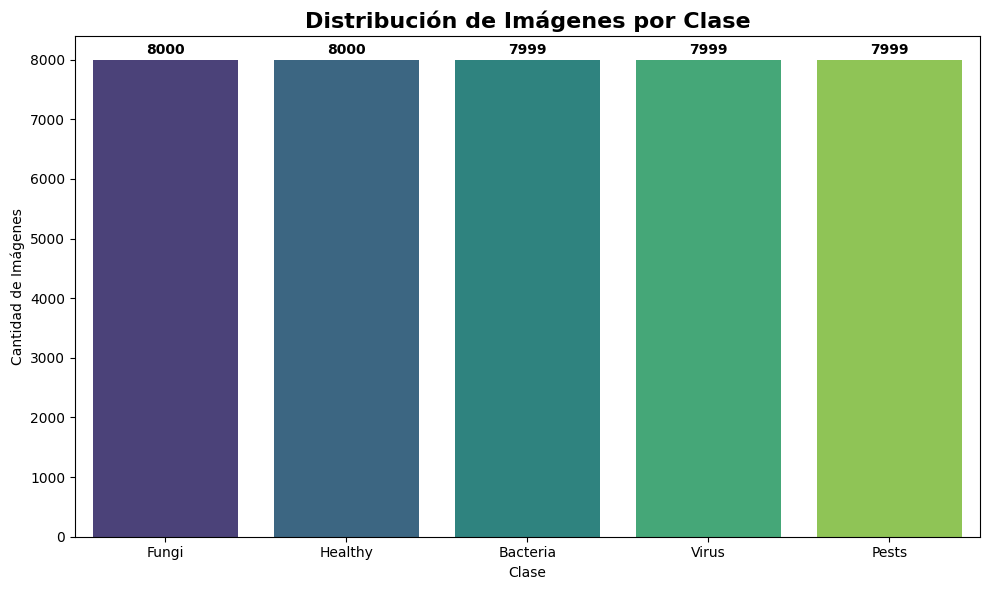

In [6]:
# Contar imágenes por clase
def contar_imagenes_por_clase(directorio):
    clases_info = {}
    for clase in os.listdir(directorio):
        clase_path = os.path.join(directorio, clase)
        if os.path.isdir(clase_path):
            imagenes = [f for f in os.listdir(clase_path)
                       if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            clases_info[clase] = len(imagenes)
    return clases_info

clases_dict = contar_imagenes_por_clase(DATA_DIR)
df_clases = pd.DataFrame(list(clases_dict.items()),
                         columns=['Clase', 'Cantidad_Imagenes'])
df_clases = df_clases.sort_values('Cantidad_Imagenes', ascending=False)

print("\n=== DISTRIBUCIÓN DEL DATASET ===")
print(df_clases.to_string(index=False))
print(f"\nTotal de imágenes: {df_clases['Cantidad_Imagenes'].sum()}")

# Visualización
plt.figure(figsize=(10, 6))
sns.barplot(data=df_clases, x='Clase', y='Cantidad_Imagenes', palette='viridis')
plt.title('Distribución de Imágenes por Clase', fontsize=16, fontweight='bold')
plt.ylabel('Cantidad de Imágenes')
plt.xlabel('Clase')
for i, v in enumerate(df_clases['Cantidad_Imagenes']):
    plt.text(i, v + 100, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Data Augmentation Avanzado

In [7]:
# Augmentation avanzado para training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 80% train, 20% validation
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='reflect'
)

# Solo rescaling para validación
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

print("Creando generadores de datos...")

train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=SEED
)

validation_generator = val_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=SEED
)

print(f"\nImágenes de entrenamiento: {train_generator.samples}")
print(f"Imágenes de validación: {validation_generator.samples}")
print(f"Clases: {train_generator.class_indices}")

Creando generadores de datos...
Found 32000 images belonging to 5 classes.
Found 7997 images belonging to 5 classes.

Imágenes de entrenamiento: 32000
Imágenes de validación: 7997
Clases: {'Bacteria': 0, 'Fungi': 1, 'Healthy': 2, 'Pests': 3, 'Virus': 4}


## 7. Construcción del modelo ConvNeXt-Large

In [8]:
def build_convnext_large_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES):
    """
    Construye ConvNeXt-Large con transfer learning
    """
    # Cargar modelo pre-entrenado (sin la capa top)
    base_model = ConvNeXtLarge(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
        pooling='avg'  # Global Average Pooling
    )

    # Congelar las capas del modelo base inicialmente
    base_model.trainable = False

    # Construir el modelo completo
    inputs = keras.Input(shape=input_shape)

    # Preprocesamiento específico de ConvNeXt
    x = tf.keras.applications.convnext.preprocess_input(inputs)

    # Modelo base
    x = base_model(x, training=False)

    # Custom head para clasificación
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(512, activation='relu', name='fc1')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    # Capa de salida (float32 para mixed precision)
    outputs = layers.Dense(num_classes, activation='softmax', dtype='float32', name='predictions')(x)

    model = keras.Model(inputs, outputs, name='ConvNeXt_Large_PathogenDetector')

    return model, base_model

print("Construyendo ConvNeXt-Large...")
model, base_model = build_convnext_large_model()

print("\nModelo creado exitosamente!")
print(f"\nTotal de parámetros: {model.count_params():,}")
print(f"Capas en el modelo base: {len(base_model.layers)}")

# Mostrar resumen
model.summary()

Construyendo ConvNeXt-Large...
785596384/785596384 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

Modelo creado exitosamente!

Total de parámetros: 197,021,893
Capas en el modelo base: 260


Model: "ConvNeXt_Large_PathogenDetector"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convnext_large (Functional)     │ (None, 1536)           │   196,230,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 197,021,893 (751.58 MB)

 Trainable params: 790,533 (3.02 MB)

 Non-trainable params: 196,231,360 (748.56 MB)

## 8. Compilación del modelo - Fase 1 (Feature Extractor)

In [9]:
# Primera fase: entrenar solo el clasificador (head)
model.compile(
    optimizer=AdamW(learning_rate=INITIAL_LR),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc')
    ]
)

print("Modelo compilado (Fase 1: Solo clasificador)")
print(f"   Optimizador: AdamW (lr={INITIAL_LR})")
print(f"   Base model: CONGELADO")
print(f"   Capas entrenables: {sum([1 for layer in model.layers if layer.trainable])}")

Modelo compilado (Fase 1: Solo clasificador)
   Optimizador: AdamW (lr=0.0001)
   Base model: CONGELADO
   Capas entrenables: 6
